# Multi-layer Perceptron Neural Network using sklearn

Sources:

https://github.com/mdeff/fma

https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score


import sys

sys.path.append('../')

from dependencies import utils

Load and create dataset using "small" tracks (1000 tracks per genre)

In [5]:
tracks = utils.load('../dependencies/fma_metadata/tracks.csv')
feats = utils.load('../dependencies/fma_metadata/features.csv')

In [6]:
small = tracks['set', 'subset'] <= 'small'

X = feats.loc[small]
y = tracks['track', 'genre_top'].loc[small]

Uncomment and run for 5 genre classification, otherwise default is 8 genres

In [7]:
#y = y.loc[(y == 'Rock') | (y == 'Electronic') | (y == 'Instrumental') | (y == 'Hip-Hop') | (y == 'Pop')]

Uncomment and run for top 5 features only, otherwise default is full features

In [8]:
#mfcc = X.iloc[:, X.columns.get_loc('mfcc')]
#rmse = X.iloc[:, X.columns.get_loc('rmse')]
#spectral_bandwidth = X.iloc[:, X.columns.get_loc('spectral_bandwidth')]
#spectral_centroid = X.iloc[:, X.columns.get_loc('spectral_centroid')]
#spectral_contrast = X.iloc[:, X.columns.get_loc('spectral_contrast')]

Create training and testing data with 80/20 split

In [9]:
print(y.value_counts())

X = X.loc[X.index.isin(y.index)]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

Electronic             1000
Experimental           1000
Folk                   1000
Hip-Hop                1000
Instrumental           1000
International          1000
Pop                    1000
Rock                   1000
Blues                     0
Classical                 0
Country                   0
Easy Listening            0
Jazz                      0
Old-Time / Historic       0
Soul-RnB                  0
Spoken                    0
Name: (track, genre_top), dtype: int64


Scale data with StandardScaler

In [10]:
sc = StandardScaler()
X_train2 = X_train.copy()
sc.fit(X_train)
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

Train initial MLP model

In [11]:
mlp = MLPClassifier(solver = 'sgd', random_state = 42, activation = 'relu', learning_rate_init = 0.1, batch_size = 300, hidden_layer_sizes = (200,100), max_iter = 100)
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)

In [12]:
print(mlp.classes_)

['Electronic' 'Experimental' 'Folk' 'Hip-Hop' 'Instrumental'
 'International' 'Pop' 'Rock']


Accuracy: 0.57625

Classification Report:
               precision    recall  f1-score   support

   Electronic       0.59      0.60      0.59       203
 Experimental       0.47      0.54      0.50       211
         Folk       0.56      0.64      0.59       181
      Hip-Hop       0.61      0.73      0.67       193
 Instrumental       0.64      0.57      0.60       215
International       0.71      0.59      0.65       208
          Pop       0.42      0.38      0.40       195
         Rock       0.65      0.58      0.61       194

     accuracy                           0.58      1600
    macro avg       0.58      0.58      0.58      1600
 weighted avg       0.58      0.58      0.58      1600



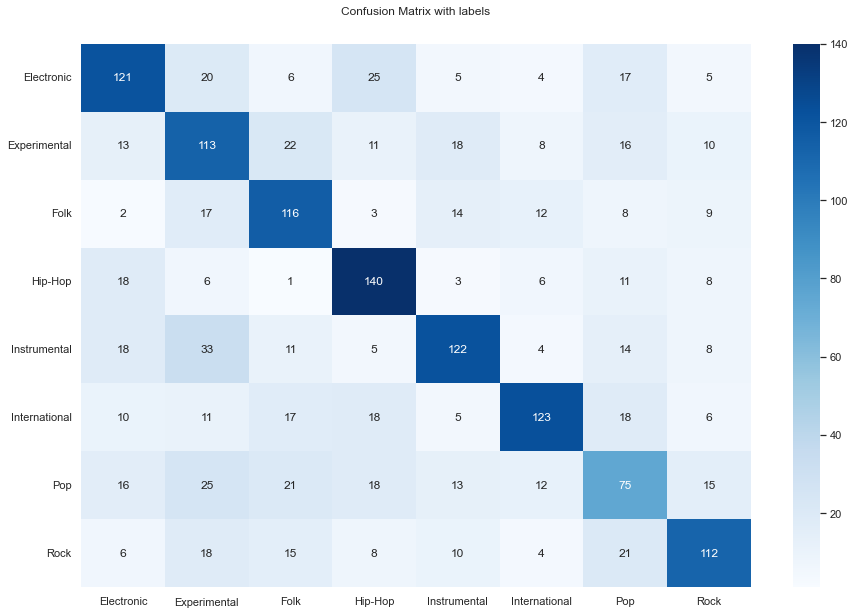

In [13]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
cf_mat = confusion_matrix(y_test, y_pred)
sns.set(rc = {'figure.figsize':(15,10)})

ax = sns.heatmap(cf_mat, annot=True, cmap='Blues', fmt='g')
ax.set_xticklabels(mlp.classes_)
kwargs = {'rotation': 'horizontal'}
ax.set_yticklabels(mlp.classes_, **kwargs)

ax.set_title('Confusion Matrix with labels\n\n')

## Display the visualization of the Confusion Matrix.
plt.show()

Hyperparameter Tuning

In [267]:
from sklearn.model_selection import GridSearchCV

learning_rate_init = [0.1, 0.2, 0.3]
max_iter = [100, 300]
hidden_layer_sizes = [(200,100), (200,50), (100,50)]
solver = ['sgd']
random_state = [42]
activation = ['logistic', 'relu']
batch_size = [100, 300]


# Make a dictionary of the grid search parameters
param_grid = dict(learning_rate_init=learning_rate_init, max_iter=max_iter, hidden_layer_sizes=hidden_layer_sizes, solver=solver, random_state=random_state, activation=activation, batch_size=batch_size)

# Build and fit the GridSearchCV
grid = GridSearchCV(estimator=mlp, param_grid=param_grid)

grid.fit(X_train, y_train)
print(grid.best_params_)

c:\Users\micha\anaconda3\envs\env1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\micha\anaconda3\envs\env1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\micha\anaconda3\envs\env1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\micha\anaconda3\envs\env1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\micha\anaconda3\envs\en

{'activation': 'logistic', 'batch_size': 100, 'hidden_layer_sizes': (200, 100), 'learning_rate_init': 0.1, 'max_iter': 100, 'random_state': 42, 'solver': 'sgd'}


Accuracy: 0.571875

Classification Report:
               precision    recall  f1-score   support

   Electronic       0.56      0.55      0.56       201
 Experimental       0.46      0.40      0.43       194
         Folk       0.61      0.67      0.64       209
      Hip-Hop       0.64      0.59      0.61       192
 Instrumental       0.57      0.57      0.57       198
International       0.63      0.72      0.67       212
          Pop       0.45      0.38      0.41       201
         Rock       0.60      0.67      0.64       193

     accuracy                           0.57      1600
    macro avg       0.57      0.57      0.57      1600
 weighted avg       0.57      0.57      0.57      1600



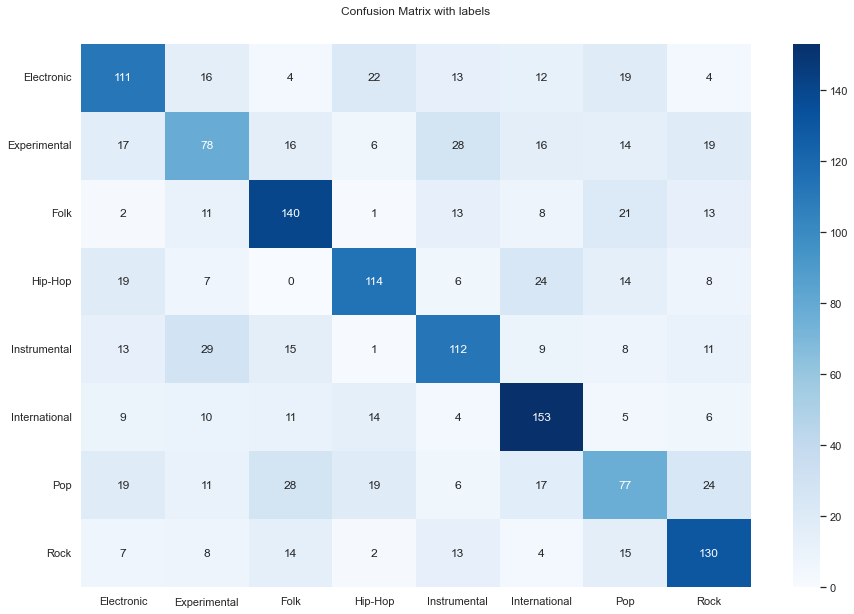

In [268]:
grid_pred = grid.predict(X_test)

print("Accuracy:", accuracy_score(y_test, grid_pred))
print("\nClassification Report:")
print(classification_report(y_test, grid_pred))
cf_mat = confusion_matrix(y_test, grid_pred)
sns.set(rc = {'figure.figsize':(15,10)})

ax = sns.heatmap(cf_mat, annot=True, cmap='Blues', fmt='g')
ax.set_xticklabels(mlp.classes_)
kwargs = {'rotation': 'horizontal'}
ax.set_yticklabels(mlp.classes_, **kwargs)

ax.set_title('Confusion Matrix with labels\n\n')

## Display the visualization of the Confusion Matrix.
plt.show()

Uncomment and run to create pkl files to be used with web app

In [14]:
#import pickle

#mlp_file = 'mlp_5_class_model.pkl'
#pickle.dump(mlp, open(mlp_file, 'wb'))

#sc = StandardScaler()
#sc.fit(X_train2)
    
#sc_file = 'mlp_5_class_sc.pkl'
#pickle.dump(sc, open(sc_file, 'wb'))